In [1]:
import sys
import os
import math
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_theme(style='whitegrid', # darkgrid, whitegrid, dark, white, ticks)
            context='notebook', # paper, notebook, talk, poster
            palette='tab10', # deep, muted, bright, pastel, dark, colorblind, hls, tab10
                      # for more info, https://seaborn.pydata.org/tutorial/color_palettes.html
             )
print(sys.version)
print(f"Seaborn version {sns.__version__}")

3.8.2 (default, Mar 11 2020, 00:28:52) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Seaborn version 0.11.2


In [2]:
# Solution we are aiming to solve for 
def Soln1D(x):
    w=0.5
    return np.exp(- (x-0.3)**2 / w**2 )

def NablaSoln1D(x):
    w=0.5
    return ( -2./w**2  + 4*( (x-0.3)**2)/w**4) * Soln1D(x)

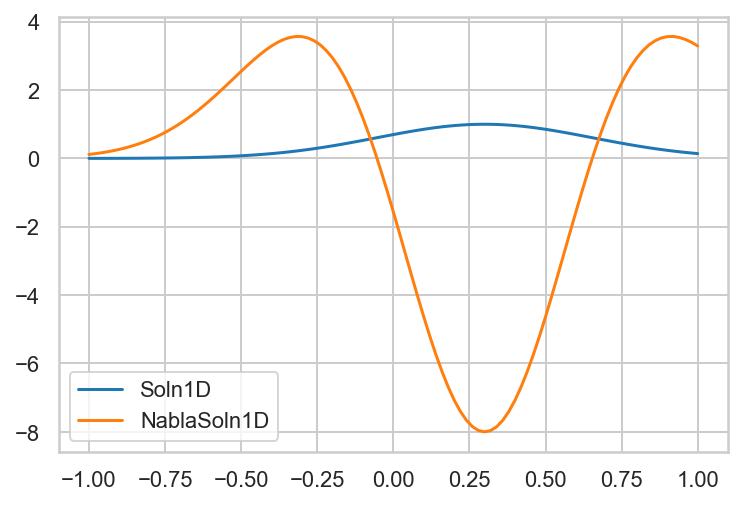

In [3]:
x=np.linspace(-1.,1., num=101)
z=Soln1D(x)
plt.plot(x, z, label='Soln1D')
plt.plot(x, NablaSoln1D(x), label='NablaSoln1D')
plt.legend();
# debugging stuff, because Harald couldn't type in formulae...
#dz=np.gradient(z,x)
#ddz=np.gradient(dz,x)
#plt.plot(x,ddz)


In [4]:
def Solve_1D_FD_LaplaceEq(N, verbose=False):

    """Demonstrate a full front-to-back solution of a 1-D Laplace equation
    with finite differences.  It solves
    
       \nabla^2 u(x) = NablaSoln1D(x),     x in [-1,1]
       
       subject to the boundary conditions

          u(x) = Soln1D(x)     x in \partial [-1,1] = {-1,1}

    N -- number of grid-points per dimension
    verbose -- if True, make a few diagnostic plots

    RETURNS
      ErrL2  - rms error of solution
    """

    # grid-spacing 
    dx = 2./(N-1)

    # allocate and fill a matrix A and a vector b, such that the solution u is given by 
    #     A u = b 
    # vectors go over all grid-points (i.e. have length N)
    # the matrix A has the size  (N, N) for a total of N^2 elements.

    b = np.zeros(N)
    A = np.ndarray( (N,N))
    A.fill(0.)

    #  fill A and b with the relevant data 
    # (1) boundary points 
    #     set A to be identity for those entries, and set the rhs to be the function-value.
    #     This will enforce Dirichlet BCs on u
    #
    A[0, 0]     = 1.;   b[0]   = Soln1D(-1.)
    A[N-1, N-1] = 1.;   b[N-1] = Soln1D(+1.)

    # (2) interior points
    #         \nabla^2u (ix, iy) = (u_{ix+1} + u_{ix-1}  - 2 u_{ix} ) / dx^2)  
    #         therefore, the A_{ij} entries are... 
    #             A_{ ix, ix }    = -2/dx^2  
    #             A_{ ix, ix+-1 } = 1/dx^2

    # NOTE:  IN PRODUCTION CODE, AVOID EXPLICIT LOOPS
    for ix in range(1,N-1):
        A[ix, ix]   = -2./dx**2; 
        A[ix, ix+1] =  1./dx**2;   
        A[ix, ix-1] =  1./dx**2;   

        # fill b with the source-term 'NablaSoln'
        b[ix] = NablaSoln1D( ix*dx -1.)

    #  here comes the work -- direct matrix inversion
    Ainv=np.linalg.inv(A)

    # now compute u = A^{-1} b.  
    u=np.dot(Ainv,b)

    # compute analytic solution
    x = np.linspace(-1.0,1.0,num=N)
    Z = Soln1D(x) # evaluation of the function on the grid

    err = u - Z
    errL2 = np.sqrt( np.sum(err*err,axis=None) / N)

    if verbose:
        fig = plt.figure(figsize=(10,5))
        fig.suptitle(f"Poisson equation with FD, N={N}")
        ax0 = fig.add_subplot(1,3, 1)
        ax0.imshow(A)
        ax0.set_title('Structure of A')

        # Plot the surface.
        ax1 = fig.add_subplot(1, 3, 2)
        ax1.plot(x, u, label='u_FD')
        ax1.plot(x, Z, label='Soln1D')
        ax1.legend();
        ax1.set_title(f"N={N}, solution")

        ax2 = fig.add_subplot(1, 3, 3)
        ax2.plot(x, u-Z)
        ax2.set_title(f"error  errL2={errL2:0.6f}");
        if N<11: print(f"A={A}")

    return errL2

A=[[  1.   0.   0.   0.   0.   0.   0.]
 [  9. -18.   9.   0.   0.   0.   0.]
 [  0.   9. -18.   9.   0.   0.   0.]
 [  0.   0.   9. -18.   9.   0.   0.]
 [  0.   0.   0.   9. -18.   9.   0.]
 [  0.   0.   0.   0.   9. -18.   9.]
 [  0.   0.   0.   0.   0.   0.   1.]]


0.04343330124825045

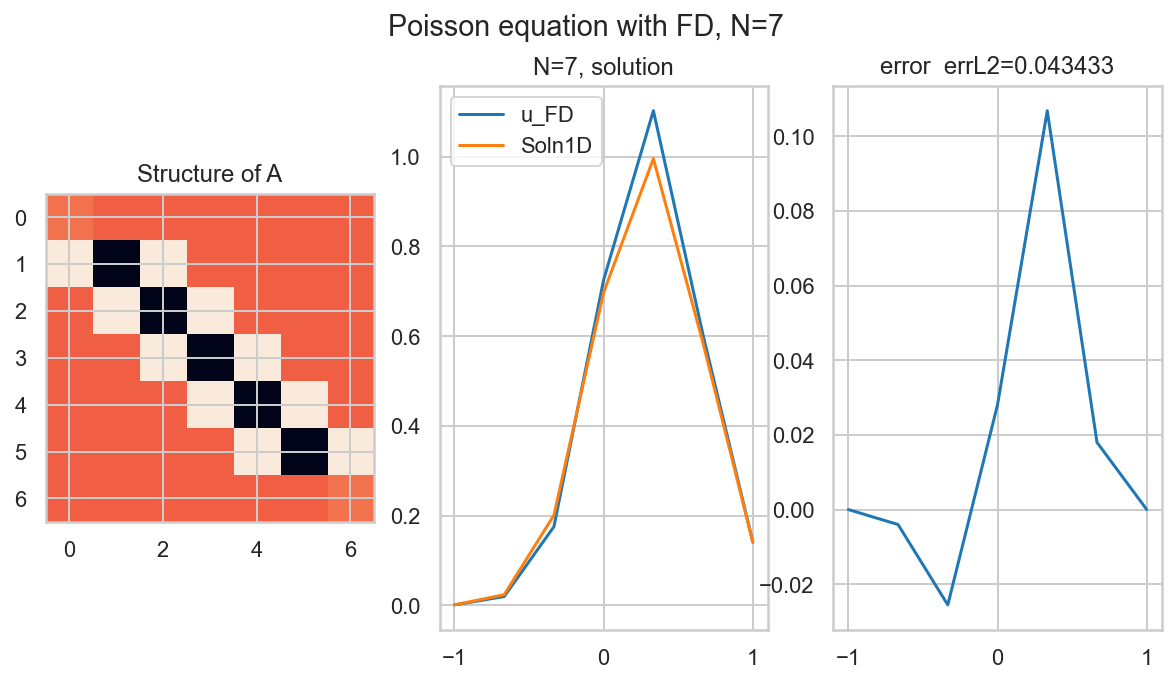

In [5]:
Solve_1D_FD_LaplaceEq(N=7,verbose=True)

0.002601443477756375

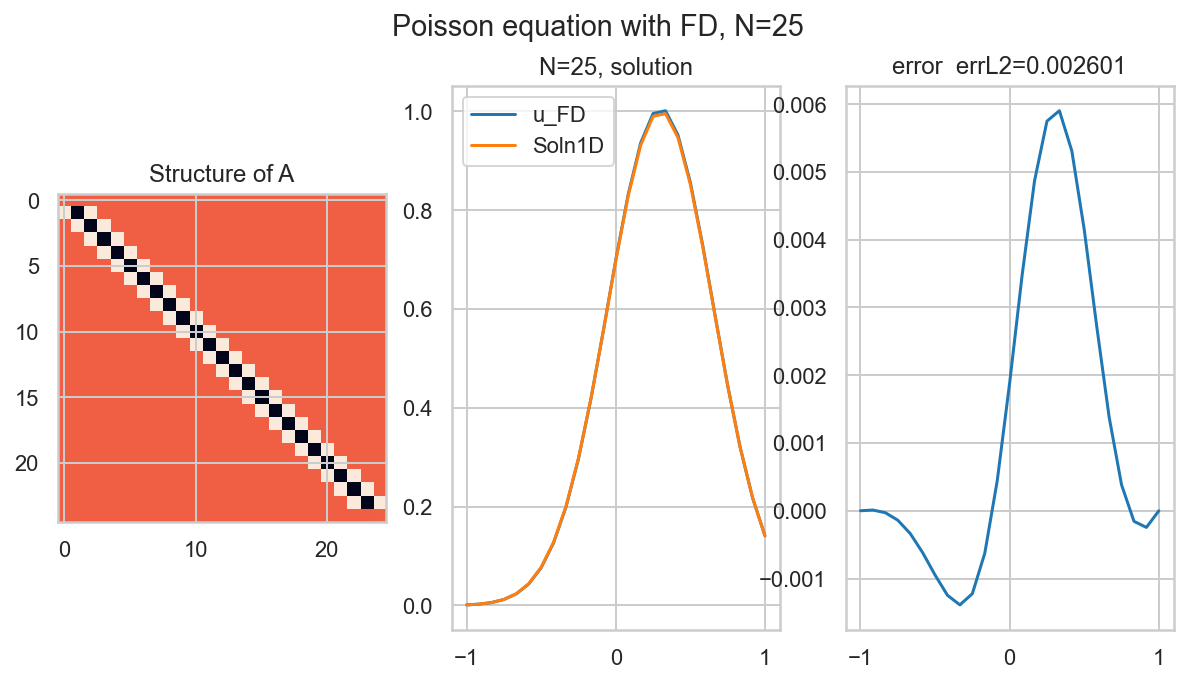

In [6]:
Solve_1D_FD_LaplaceEq(N=25,verbose=True)

In [7]:
N_arr=[5,9,17,25,33,49,65,81,97,113,257, 512, 1025]

err_arr=[]
for N in N_arr:
    print(f"Solving for N={N}...", end="", flush=True)
    err = Solve_1D_FD_LaplaceEq(N=N)
    print(f"ErrL2={err}", flush=True)
    err_arr.append(err)

# numpy arrays are easier for arithmetic during plotting 
N_arr=np.array(N_arr)
err_arr=np.array(err_arr)


Solving for N=5...ErrL2=0.07359179554819895
Solving for N=9...ErrL2=0.023667185178648138
Solving for N=17...ErrL2=0.005839225907450396
Solving for N=25...ErrL2=0.002601443477756375
Solving for N=33...ErrL2=0.0014668505196688629
Solving for N=49...ErrL2=0.000654034231420794
Solving for N=65...ErrL2=0.00036859680760311026
Solving for N=81...ErrL2=0.00023619472349974924
Solving for N=97...ErrL2=0.00016416632675219237
Solving for N=113...ErrL2=0.00012068903306160197
Solving for N=257...ErrL2=2.315324586305483e-05
Solving for N=512...ErrL2=5.816411664587199e-06
Solving for N=1025...ErrL2=1.4491231611492234e-06


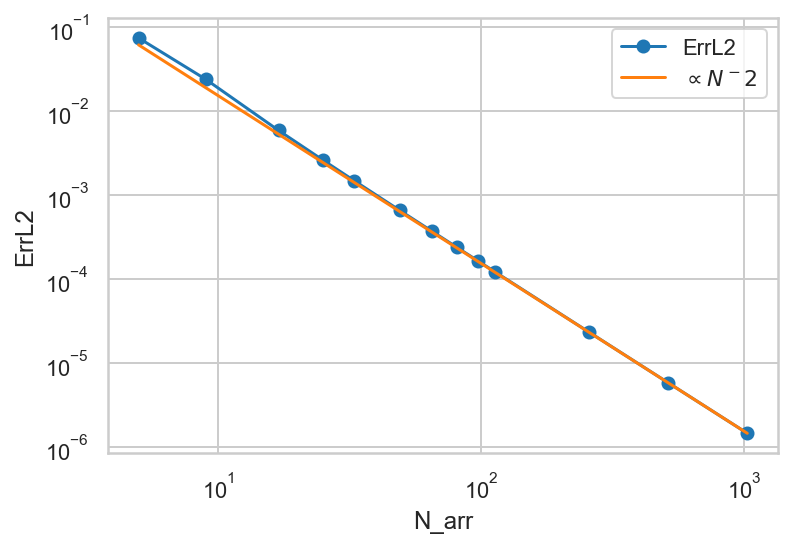

In [8]:
fig,ax=plt.subplots(1,1)
ax.loglog(N_arr, err_arr, '-o', label='ErrL2')
frac= N_arr / N_arr[-1] # helper for scaling line
ax.plot(N_arr, err_arr[-1] * frac**(-2), label =r"$\propto N^-2$" )
ax.set_xlabel('N_arr')
ax.set_ylabel('ErrL2');
ax.legend();

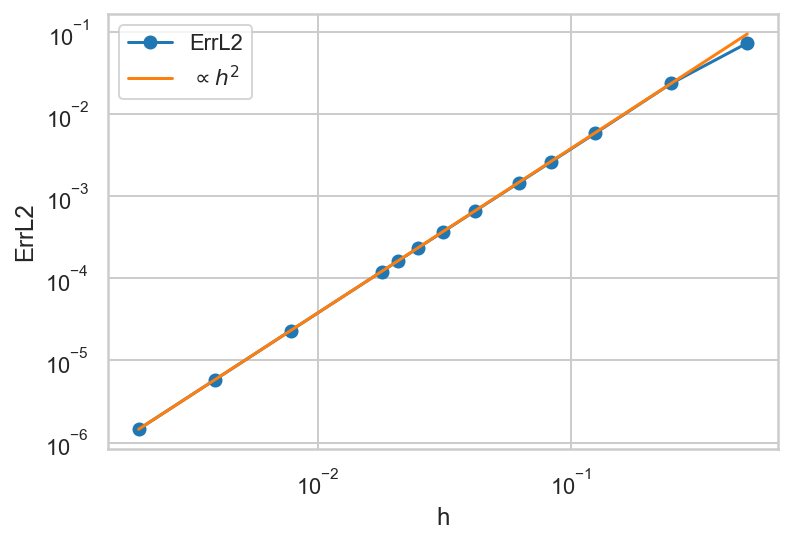

In [9]:
# plot with h on x-axis
h_arr = 2./(N_arr-1)
fig,ax=plt.subplots(1,1)
ax.loglog(h_arr, err_arr, '-o', label='ErrL2')
frac= h_arr / h_arr[-1] # helper for scaling line
ax.plot(h_arr, err_arr[-1] * frac**2, label =r"$\propto h^2$" )
ax.set_xlabel('h')
ax.set_ylabel('ErrL2');
ax.legend();


### Spectral methods with Chebyshev polynomials

In [10]:
def Solve_1D_Cheby_LaplaceEq(N, verbose=False):

    """Demonstrate a full front-to-back solution of a 1-D Laplace equation
    with Chebyshev polynomials.  It solves
    
       \nabla^2 u(x) = NablaSoln1D(x),     x in [-1,1]
       
       subject to the boundary conditions

          u(x) = Soln1D(x)     x in \partial [-1,1] = {-1,1}

    N -- number of grid-points per dimension
    verbose -- if True, make a few diagnostic plots

    RETURNS
      ErrL2  - rms error of solution
    """

    # collocation points
    xi = np.cos(np.pi*np.arange(N)/(N-1))

    # helper arrays
    c=np.ones(N)
    c[0]=2.
    cbar=np.ones(N)
    cbar[0]=2.; cbar[N-1]=2.

    # trafo matrix from spectral to grid-points
    ToPhys = np.ndarray( (N,N))
    for k in range(N):
        ToPhys[:,k]=np.cos(k*np.arccos(xi))
    
    # trafo matrix from grid-points to spectral coefficients
    ToSpec = np.ndarray( (N,N))
    for k in range(N):
        ToSpec[k,:]=2./((N-1)*cbar[k]*cbar[:]) * ToPhys[:,k]

    #print(ToSpec @ ToPhys)
    #print(ToPhys @ ToSpec)
    #return 
    
    # spectral differentiaton matrix
    Dtilde=np.ndarray( (N,N) )
    Dtilde.fill(0.)
    # I am sure there's a better way
    for k in reversed(range(N-1)):
        if k<=N-3:
            Dtilde[k,:]=1/c[k]*Dtilde[k+2,:]
        Dtilde[k,k+1]+=2*(k+1)/c[k]

    # full second derivative physical-to-physical differentiaton matrix
    D2 = ToPhys @ Dtilde @ Dtilde @ ToSpec


    # construct full discrete operator matrix w/ boundary conditions
    A=np.ndarray( (N,N) )
    A.fill(0)
    A[0,0]=1
    A[1:N-1,:] = D2[1:N-1,:]
    A[N-1,N-1]=1

    # right-hand-side
    b = NablaSoln1D(xi)
    b[0] = Soln1D(xi[0])  # note xi[0] = +1
    b[N-1] = Soln1D(xi[N-1])    # note xi[N-1]=-1
    
    
    #  here comes the work -- direct matrix inversion
    Ainv=np.linalg.inv(A)

    # now compute u = A^{-1} b.  
    u=np.dot(Ainv,b)

    # compute analytic solution on much finer grid
    x_fine = np.linspace(-1.0,1.0,num=100*N+1)
    u_fine = np.zeros_like(x_fine)

    uspec = np.dot(ToSpec, u)
    for k in range(N):
        u_fine += uspec[k] * np.cos(k*np.arccos(x_fine))

    Z = Soln1D(x_fine) # evaluation of the function on the grid

    err = u_fine - Z
    errL2 = np.sqrt( np.sum(err*err,axis=None) / len(err))

    if verbose:
        fig = plt.figure(figsize=(10,5))
        fig.suptitle(f"Poisson equation with Chebyshev, N={N}")
        ax0 = fig.add_subplot(1,3, 1)
        ax0.imshow(A)
        ax0.set_title('Structure of A')

        # Plot the surface.
        ax1 = fig.add_subplot(1, 3, 2)
        ax1.plot(x_fine, u_fine, label='u_spec')
        ax1.plot(x_fine, Z, label='Soln1D')
        ax1.legend();
        ax1.set_title(f"N={N}, solution")

        ax2 = fig.add_subplot(1, 3, 3)
        ax2.plot(x_fine, u_fine-Z)
        ax2.set_title(f"error  errL2={errL2:0.6f}");
        if N<6: print(A)

    return errL2

[[  1.           0.           0.           0.           0.        ]
 [  9.24264069 -14.           6.          -2.           0.75735931]
 [ -1.           4.          -6.           4.          -1.        ]
 [  0.75735931  -2.           6.         -14.           9.24264069]
 [  0.           0.           0.           0.           1.        ]]


0.34728440133324656

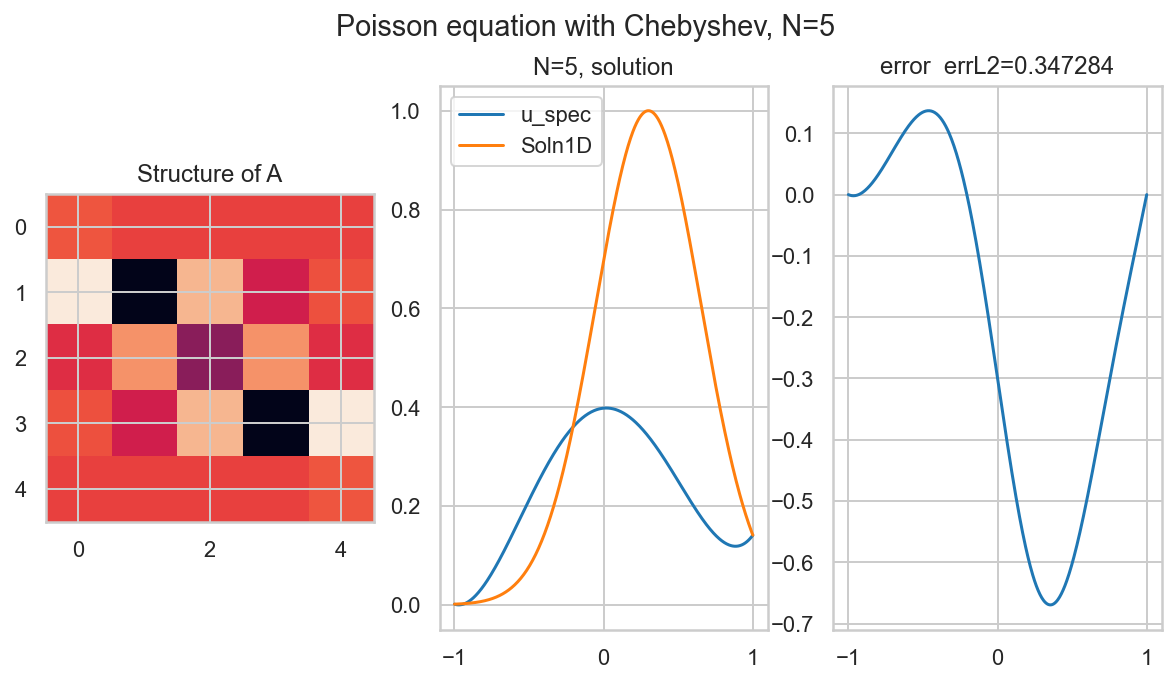

In [11]:
Solve_1D_Cheby_LaplaceEq(5, verbose=True)

0.18621869315826528

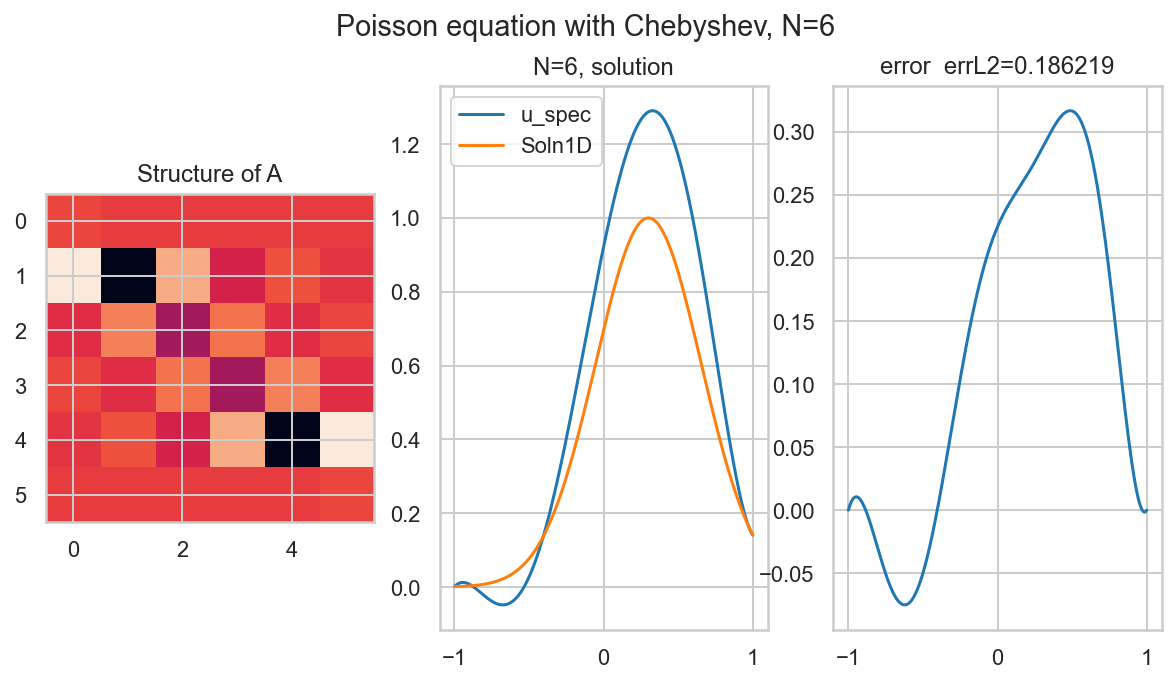

In [12]:
Solve_1D_Cheby_LaplaceEq(6, verbose=True)

0.07420463334353357

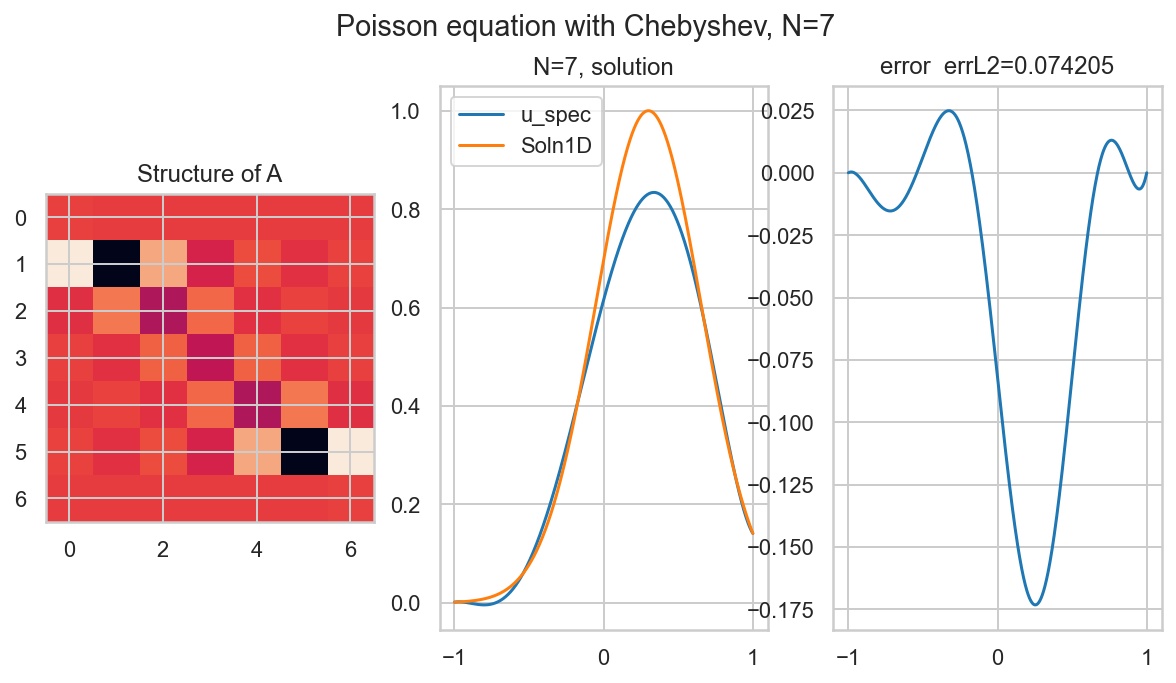

In [13]:
Solve_1D_Cheby_LaplaceEq(7, verbose=True)

0.0028470138608692134

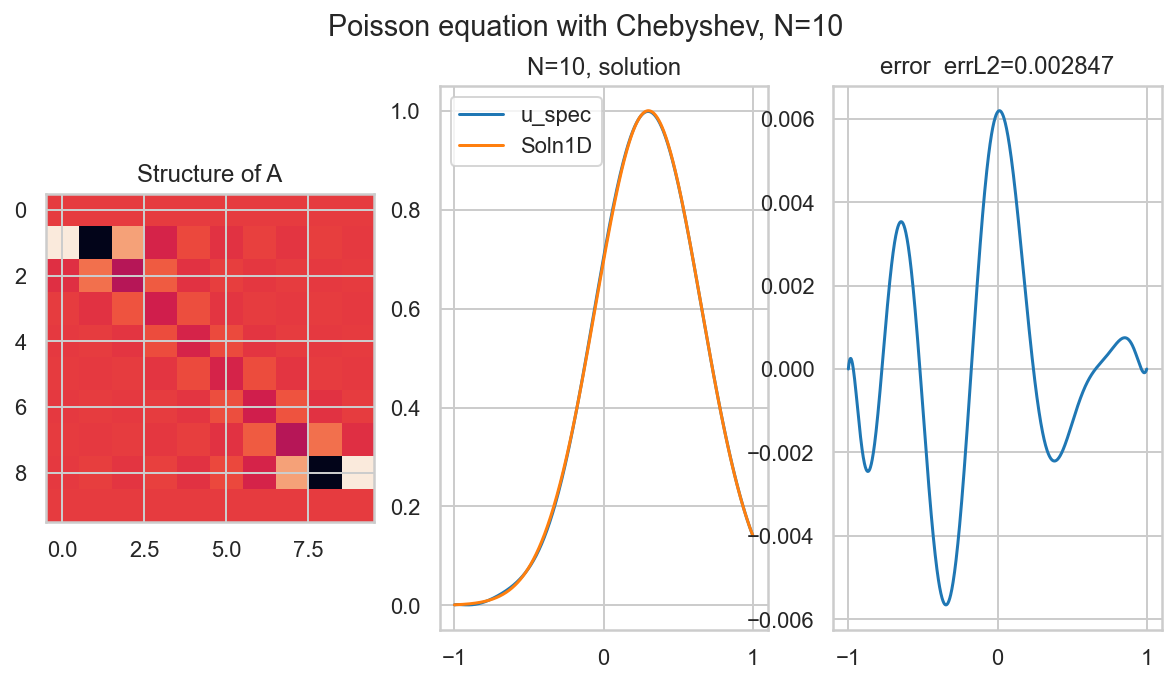

In [14]:
Solve_1D_Cheby_LaplaceEq(10, verbose=True)

In [15]:
N_arr2=np.arange(5,50,2)

err_arr2=[]
for N in N_arr2:
    err = Solve_1D_Cheby_LaplaceEq(N=N)
    err_arr2.append(err)

# numpy arrays are easier for arithmetic during plotting 
N_arr2=np.array(N_arr2)
err_arr2=np.array(err_arr2)


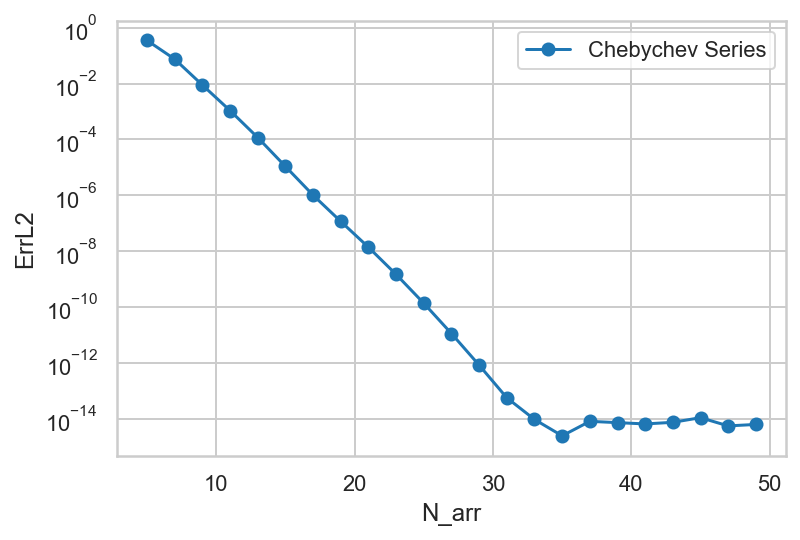

In [16]:
fig,ax=plt.subplots(1,1)
ax.semilogy(N_arr2, err_arr2, '-o', label='Chebychev Series')
#ax.plot(N_arr, err_arr, label='2nd order FD')
ax.set_xlabel('N_arr')
ax.set_ylabel('ErrL2');
ax.legend();


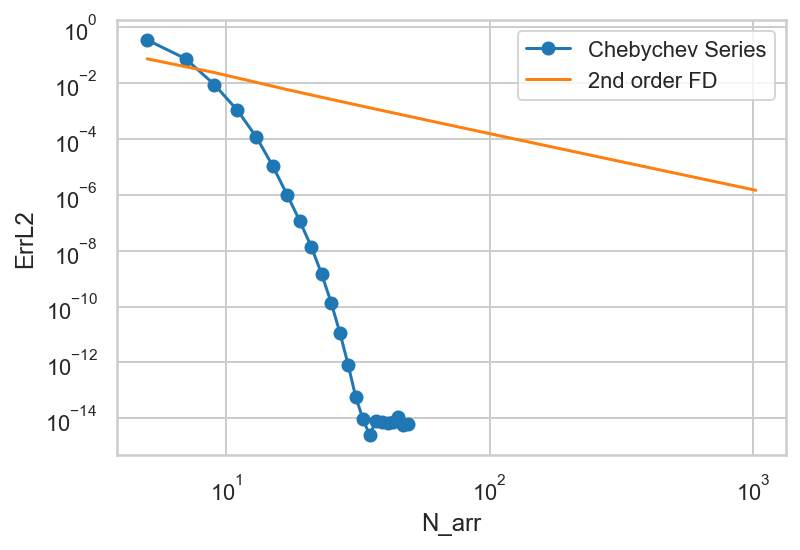

In [17]:
fig,ax=plt.subplots(1,1)
ax.loglog(N_arr2, err_arr2, '-o', label='Chebychev Series')
ax.plot(N_arr, err_arr, label='2nd order FD')
ax.set_xlabel('N_arr')
ax.set_ylabel('ErrL2');
ax.legend();
